In [12]:
import torch

# Vérifie si CUDA est disponible et donc si un GPU est utilisable
if torch.cuda.is_available():
    print(f"GPU disponible : {torch.cuda.get_device_name(0)}")
else:
    print("GPU non disponible, PyTorch va utiliser le CPU.")


GPU non disponible, PyTorch va utiliser le CPU.


# Introducing self attention

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import gensim
import nltk
from nltk.data import find

In [3]:
nltk.download('word2vec_sample')

[nltk_data] Downloading package word2vec_sample to C:\Users\Roc-
[nltk_data]     Antony.COCO\AppData\Roaming\nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!


True

In [4]:
def softmax(x, axis=0):
    return np.exp(x) / np.sum(np.exp(x), axis=axis)

In [5]:
def get_word2vec_embedding(words):
        word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
        model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)
        output = []
        word_pass=[]
        for word in words:
            try:
                output.append(np.array(model.word_vec(word)))
                word_pass.append(word)
            except:
                # display error message if word is not in the model
                print(f"Word '{word}' not found in Word2Vec model.")

        embeddings = np.array(output)
        del model # to save memory
        return embeddings, word_pass

img = plt.imread('attention.png')

In [6]:
def dot_product_attention(hidden_states, previous_state):

    # [T,d]*[d,N] -> [T,N]
    scores = np.matmul(previous_state, hidden_states.T)
    w_n = softmax(scores)

    # [T,N]*[N,d] -> [T,d]
    c_t = np.matmul(w_n, hidden_states)

    return w_n, c_t

In [26]:
def plot_attention_weight_matrix(weight_matrix, x_ticks, y_ticks):
    """Function that takes in a weight matrix and plots it with custom axis ticks"""
    plt.figure(figsize=(15, 7))
    ax = sns.heatmap(weight_matrix, cmap="Blues")
    plt.xticks(np.arange(weight_matrix.shape[1]) + 0.5, x_ticks, rotation=45)
    plt.yticks(np.arange(weight_matrix.shape[0]) + 0.5, y_ticks, rotation=0)
    plt.title("Attention matrix")
    plt.xlabel("Attention score")
    plt.show()

C:\Users\Roc-Antony.COCO\AppData\Local\Temp\ipykernel_20244\1895853493.py:15: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  output.append(np.array(model.word_vec(word)))


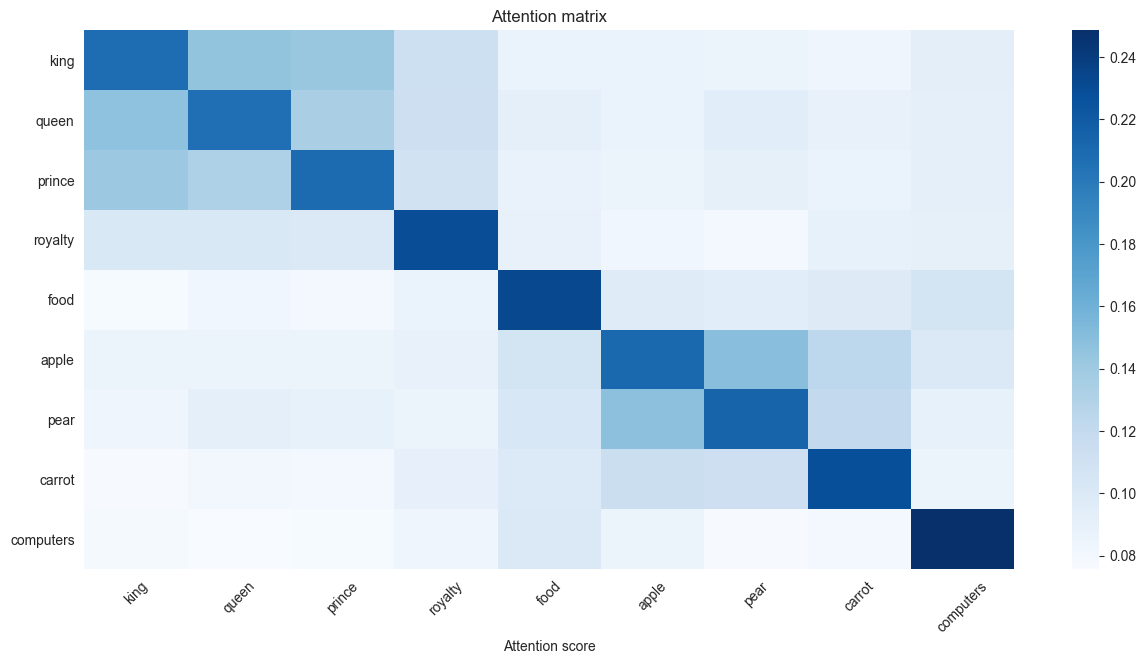

In [28]:

words = ["king", "queen", "prince", "royalty", "food", "apple", "pear", "carrot", "computers"]
word_embeddings, words = get_word2vec_embedding(words)
weights, _ = dot_product_attention(word_embeddings, word_embeddings)
plot_attention_weight_matrix(weights, words, words)


In order to get closer to the Transformer we will neeed to understand Se;f Attention. this concept simply relates attention with a database. In a database you have a key value pair, and with a query you get a key and with that key you return the value, right?

In self-attention ( or sometimes called Q, K, V attention) we do the same, but instead of getting one key we will get:

$$
a_{i, k} = similarity(Q_i, K_k)
$$

Therefore

$$
c_i = ∑_{k}a_{i,k}*v_k
$$

Which basically means we get a weighted average of ALL the values for every input word we want to calculate the alignment. Therefore the term self attention. The diference with the previous attention is that before the similarity function was the dot product, and the matrices K,Q,V where the identity (only ones in the diagonal) and here they are learneable!

In [29]:
def embed_sentence(sentence):
    # Embed a sentence using word2vec; for example use cases only.
    sentence = re.sub(r"[^\w\s]", "", sentence)
    words = sentence.split()
    word_vector_sequence, words = get_word2vec_embedding(words)
    return np.expand_dims(word_vector_sequence, axis=0), words

## Seeing the attention

$$
\operatorname{Attention}(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}\right) V
$$


In [30]:
def scaled_dot_product_attention(Q, K, V):
    """
    Function that computes the scaled dot-product attention.
    """
    d_k = Q.shape[-1]
    """ Proposed by Vaswani et al. in the paper 'Attention is All You Need'."""
    # scores = np.matmul(Q, K.transpose(-2, -1)) / np.sqrt(d_k)
    # weights = torch.nn.functional.softmax(scores, dim=-1)
    # attention_weigth = torch.matmul(weights, V)
    # value = torch.matmul(attention_weigth, V)
    """ ------------------------------------------ """
    """ It is very important to remark all of this later will be done by the Tensorflow or PyTorch! """
    scaled_logits = np.matmul(Q, np.swapaxes(K, -2, -1)) / np.sqrt(d_k)
    attention_weigth = softmax(scaled_logits, axis=-1)
    value = np.matmul(attention_weigth, V)
    return attention_weigth, value

In [84]:
sentence = "I love coke, but eat steak"
word_embeddings, words = embed_sentence(sentence)
word_embeddings.shape

C:\Users\Roc-Antony.COCO\AppData\Local\Temp\ipykernel_20244\1895853493.py:15: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  output.append(np.array(model.word_vec(word)))


(1, 6, 300)

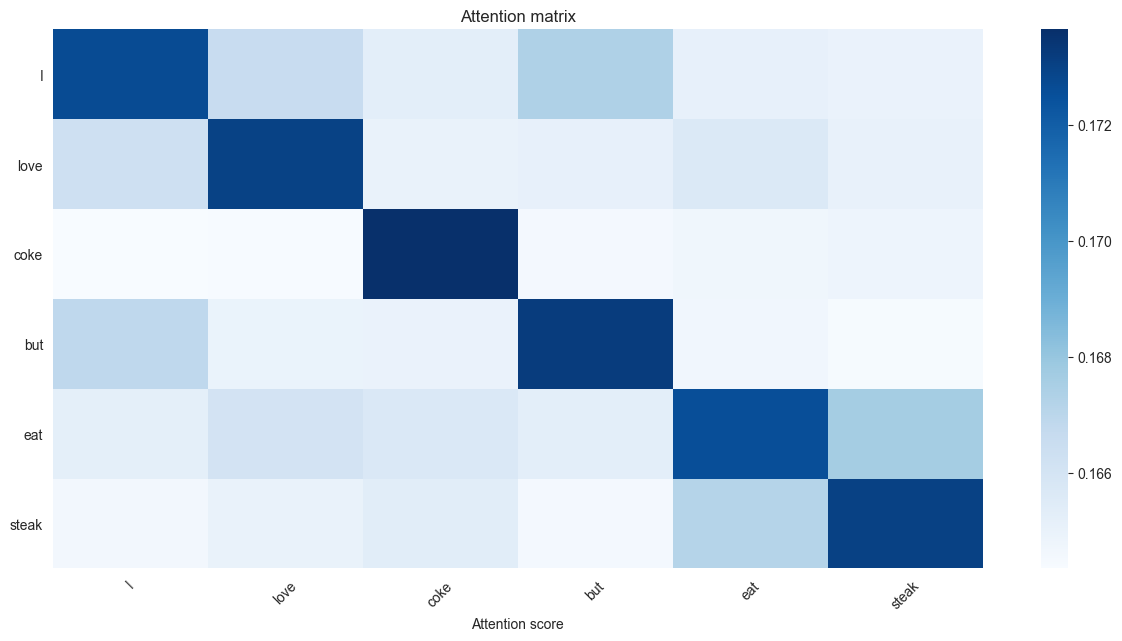

In [85]:
Q = K = V = word_embeddings   # Para no entrenar

# calculate weights and plot
attention_weights, values = scaled_dot_product_attention(Q, K, V)
words = re.sub(r"[^\w\s]", "", sentence).split()
plot_attention_weight_matrix(attention_weights[0], words, words)